In this sheet I will apply Convolutional Neural Networks for stock prediction of company X stock price. I will divide data from last N years into chunks. Every day contains one value (PREDICTION_LABEL). Predicted output has two classes: whether stock will go up or down or stay constant \$\{PREDICTION_AFTER_DAYS\} days after last input.

In [1]:
OBSERVATION_TIME = 200
PREDICTION_AFTER_DAYS = 20
EPOCHS = 250
TEST_SIZE = 0.1
RANDOM_SPLIT = False
NORMALIZED_CHUNKS = True
PREDICTION_LABEL = 'Open'

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

Parameter RANDOM_SPLIT is responsible for that feature. If True, then data set is split randomly into train/test set (network knows sets from the future). When False, then split is chronological - network works like in real world.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/AAPL.csv')
df.reindex(index=df.index[::-1])

df.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000
5,2005-05-25,5.642857,5.707143,5.617143,5.682857,4.919635,99001700
6,2005-05-26,5.705714,5.848571,5.705714,5.820000,5.038360,131380200
7,2005-05-27,5.805714,5.827143,5.715714,5.794286,5.016098,79002000
8,2005-05-31,5.808571,5.820000,5.654286,5.680000,4.917161,101051300
9,2005-06-01,5.698571,5.822857,5.694286,5.757143,4.983943,113453200


In [3]:
# PREPROCESSING

def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

In [4]:
observed_chunks[2]
observation_results[2]

0

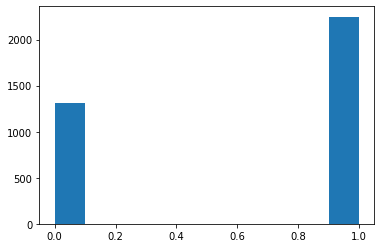

1    2248
0    1307
dtype: int64

In [5]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

pd.Series(observation_results).value_counts()

In [6]:
# NORMALIZATION

def normalize_chunk(chunk):
    df = chunk.copy()
    for label_to_normalize in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        np_arr = df[label_to_normalize].to_numpy()
        df[label_to_normalize] = pd.Series((np.array(np_arr) - np.mean(np_arr)) / np.std(np_arr))
    return df

def normalize_chunks(chunks):
    return list(map(lambda x: normalize_chunk(x), chunks))

observed_chunks = normalize_chunks(observed_chunks) if NORMALIZED_CHUNKS else observed_chunks

In [7]:
# TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[[PREDICTION_LABEL]].to_numpy(), observed_chunks)))
Y = np.array(observation_results).astype('float32')

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3199, 200, 1), (3199,), (356, 200, 1), (356,))

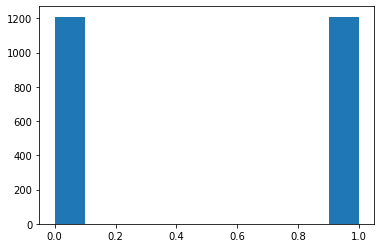

1.0    1209
0.0    1209
dtype: int64

In [8]:
# UNDERSAMPLING TRAINING SET

import random

def undersample_and_shuffle(X, Y):
    count_class_1, count_class_0 = pd.Series(Y).value_counts()

    lower_count = count_class_0 if count_class_0 < count_class_1 else count_class_1
    lower_class = 0 if count_class_0 < count_class_1 else 1
    
    diff = abs(count_class_0 - count_class_1)
    
    vec0 = random.sample([(x, y) for x, y in zip(X, Y) if y == 0], lower_count)
    vec1 = random.sample([(x, y) for x, y in zip(X, Y) if y == 1], lower_count)

    
    vec = vec0 + vec1
    random.shuffle(vec)
    return np.array(list(map(lambda x: x[0], vec))), np.array(list(map(lambda x: x[1], vec)))
    
X_train_balanced, Y_train_balanced = undersample_and_shuffle(X_train, Y_train)

plt.hist(Y_train_balanced)
plt.show()

pd.Series(Y_train_balanced).value_counts()

In [9]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (OBSERVATION_TIME, 1), filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 16)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 8)            648       
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 8)            32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 200, 8)           

In [10]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=METRICS)

In [11]:

history = model.fit(x=X_train_balanced, 
                    y=Y_train_balanced, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True)

model.save("model-binary.h5")
model.save_weights('model-binary-weights.h5')

Train on 2418 samples, validate on 356 samples
Epoch 1/250
2418/2418 [==============================] - 1s 429us/step - loss: 0.8115 - tp: 534.0000 - fp: 506.0000 - tn: 703.0000 - fn: 675.0000 - accuracy: 0.5116 - precision: 0.5135 - recall: 0.4417 - auc: 0.5183 - val_loss: 0.7236 - val_tp: 66.0000 - val_fp: 22.0000 - val_tn: 76.0000 - val_fn: 192.0000 - val_accuracy: 0.3989 - val_precision: 0.7500 - val_recall: 0.2558 - val_auc: 0.4864
Epoch 2/250
2418/2418 [==============================] - 0s 148us/step - loss: 0.7389 - tp: 622.0000 - fp: 513.0000 - tn: 696.0000 - fn: 587.0000 - accuracy: 0.5451 - precision: 0.5480 - recall: 0.5145 - auc: 0.5579 - val_loss: 0.7088 - val_tp: 122.0000 - val_fp: 50.0000 - val_tn: 48.0000 - val_fn: 136.0000 - val_accuracy: 0.4775 - val_precision: 0.7093 - val_recall: 0.4729 - val_auc: 0.5375
Epoch 3/250
2418/2418 [==============================] - 0s 148us/step - loss: 0.7153 - tp: 671.0000 - fp: 542.0000 - tn: 667.0000 - fn: 538.0000 - accuracy: 0.5533

Epoch 22/250
2418/2418 [==============================] - 0s 146us/step - loss: 0.5738 - tp: 862.0000 - fp: 378.0000 - tn: 831.0000 - fn: 347.0000 - accuracy: 0.7002 - precision: 0.6952 - recall: 0.7130 - auc: 0.7682 - val_loss: 0.7145 - val_tp: 80.0000 - val_fp: 4.0000 - val_tn: 94.0000 - val_fn: 178.0000 - val_accuracy: 0.4888 - val_precision: 0.9524 - val_recall: 0.3101 - val_auc: 0.7783
Epoch 23/250
2418/2418 [==============================] - 0s 147us/step - loss: 0.5635 - tp: 850.0000 - fp: 352.0000 - tn: 857.0000 - fn: 359.0000 - accuracy: 0.7060 - precision: 0.7072 - recall: 0.7031 - auc: 0.7808 - val_loss: 0.7268 - val_tp: 96.0000 - val_fp: 11.0000 - val_tn: 87.0000 - val_fn: 162.0000 - val_accuracy: 0.5140 - val_precision: 0.8972 - val_recall: 0.3721 - val_auc: 0.6789
Epoch 24/250
2418/2418 [==============================] - 0s 144us/step - loss: 0.5624 - tp: 844.0000 - fp: 348.0000 - tn: 861.0000 - fn: 365.0000 - accuracy: 0.7051 - precision: 0.7081 - recall: 0.6981 - auc: 0

Epoch 43/250
2418/2418 [==============================] - 0s 156us/step - loss: 0.4849 - tp: 941.0000 - fp: 273.0000 - tn: 936.0000 - fn: 268.0000 - accuracy: 0.7763 - precision: 0.7751 - recall: 0.7783 - auc: 0.8544 - val_loss: 0.8136 - val_tp: 83.0000 - val_fp: 18.0000 - val_tn: 80.0000 - val_fn: 175.0000 - val_accuracy: 0.4579 - val_precision: 0.8218 - val_recall: 0.3217 - val_auc: 0.6307
Epoch 44/250
2418/2418 [==============================] - 0s 159us/step - loss: 0.4737 - tp: 948.0000 - fp: 269.0000 - tn: 940.0000 - fn: 261.0000 - accuracy: 0.7808 - precision: 0.7790 - recall: 0.7841 - auc: 0.8619 - val_loss: 0.7802 - val_tp: 93.0000 - val_fp: 7.0000 - val_tn: 91.0000 - val_fn: 165.0000 - val_accuracy: 0.5169 - val_precision: 0.9300 - val_recall: 0.3605 - val_auc: 0.7411
Epoch 45/250
2418/2418 [==============================] - 0s 177us/step - loss: 0.4762 - tp: 941.0000 - fp: 258.0000 - tn: 951.0000 - fn: 268.0000 - accuracy: 0.7825 - precision: 0.7848 - recall: 0.7783 - auc: 0

Epoch 64/250
2418/2418 [==============================] - 0s 154us/step - loss: 0.4106 - tp: 998.0000 - fp: 220.0000 - tn: 989.0000 - fn: 211.0000 - accuracy: 0.8218 - precision: 0.8194 - recall: 0.8255 - auc: 0.9005 - val_loss: 0.7749 - val_tp: 107.0000 - val_fp: 26.0000 - val_tn: 72.0000 - val_fn: 151.0000 - val_accuracy: 0.5028 - val_precision: 0.8045 - val_recall: 0.4147 - val_auc: 0.6789
Epoch 65/250
2418/2418 [==============================] - 0s 157us/step - loss: 0.3882 - tp: 1010.0000 - fp: 185.0000 - tn: 1024.0000 - fn: 199.0000 - accuracy: 0.8412 - precision: 0.8452 - recall: 0.8354 - auc: 0.9152 - val_loss: 0.8883 - val_tp: 102.0000 - val_fp: 16.0000 - val_tn: 82.0000 - val_fn: 156.0000 - val_accuracy: 0.5169 - val_precision: 0.8644 - val_recall: 0.3953 - val_auc: 0.6380
Epoch 66/250
2418/2418 [==============================] - 0s 158us/step - loss: 0.4091 - tp: 1000.0000 - fp: 214.0000 - tn: 995.0000 - fn: 209.0000 - accuracy: 0.8251 - precision: 0.8237 - recall: 0.8271 - 

Epoch 85/250
2418/2418 [==============================] - 0s 169us/step - loss: 0.3562 - tp: 1028.0000 - fp: 182.0000 - tn: 1027.0000 - fn: 181.0000 - accuracy: 0.8499 - precision: 0.8496 - recall: 0.8503 - auc: 0.9267 - val_loss: 0.8602 - val_tp: 95.0000 - val_fp: 21.0000 - val_tn: 77.0000 - val_fn: 163.0000 - val_accuracy: 0.4831 - val_precision: 0.8190 - val_recall: 0.3682 - val_auc: 0.6763
Epoch 86/250
2418/2418 [==============================] - 0s 164us/step - loss: 0.3446 - tp: 1044.0000 - fp: 165.0000 - tn: 1044.0000 - fn: 165.0000 - accuracy: 0.8635 - precision: 0.8635 - recall: 0.8635 - auc: 0.9335 - val_loss: 0.8705 - val_tp: 88.0000 - val_fp: 13.0000 - val_tn: 85.0000 - val_fn: 170.0000 - val_accuracy: 0.4860 - val_precision: 0.8713 - val_recall: 0.3411 - val_auc: 0.7474
Epoch 87/250
2418/2418 [==============================] - 0s 161us/step - loss: 0.3528 - tp: 1021.0000 - fp: 182.0000 - tn: 1027.0000 - fn: 188.0000 - accuracy: 0.8470 - precision: 0.8487 - recall: 0.8445 -

Epoch 106/250
2418/2418 [==============================] - 1s 217us/step - loss: 0.3070 - tp: 1055.0000 - fp: 148.0000 - tn: 1061.0000 - fn: 154.0000 - accuracy: 0.8751 - precision: 0.8770 - recall: 0.8726 - auc: 0.9482 - val_loss: 0.8453 - val_tp: 110.0000 - val_fp: 12.0000 - val_tn: 86.0000 - val_fn: 148.0000 - val_accuracy: 0.5506 - val_precision: 0.9016 - val_recall: 0.4264 - val_auc: 0.7088
Epoch 107/250
2418/2418 [==============================] - 0s 188us/step - loss: 0.3089 - tp: 1063.0000 - fp: 140.0000 - tn: 1069.0000 - fn: 146.0000 - accuracy: 0.8817 - precision: 0.8836 - recall: 0.8792 - auc: 0.9482 - val_loss: 0.9027 - val_tp: 105.0000 - val_fp: 14.0000 - val_tn: 84.0000 - val_fn: 153.0000 - val_accuracy: 0.5309 - val_precision: 0.8824 - val_recall: 0.4070 - val_auc: 0.6879
Epoch 108/250
2418/2418 [==============================] - 0s 182us/step - loss: 0.3045 - tp: 1076.0000 - fp: 159.0000 - tn: 1050.0000 - fn: 133.0000 - accuracy: 0.8792 - precision: 0.8713 - recall: 0.8

Epoch 127/250
2418/2418 [==============================] - 0s 154us/step - loss: 0.2755 - tp: 1069.0000 - fp: 118.0000 - tn: 1091.0000 - fn: 140.0000 - accuracy: 0.8933 - precision: 0.9006 - recall: 0.8842 - auc: 0.9590 - val_loss: 0.9000 - val_tp: 111.0000 - val_fp: 21.0000 - val_tn: 77.0000 - val_fn: 147.0000 - val_accuracy: 0.5281 - val_precision: 0.8409 - val_recall: 0.4302 - val_auc: 0.6791
Epoch 128/250
2418/2418 [==============================] - 0s 154us/step - loss: 0.2651 - tp: 1085.0000 - fp: 129.0000 - tn: 1080.0000 - fn: 124.0000 - accuracy: 0.8954 - precision: 0.8937 - recall: 0.8974 - auc: 0.9625 - val_loss: 0.8218 - val_tp: 107.0000 - val_fp: 18.0000 - val_tn: 80.0000 - val_fn: 151.0000 - val_accuracy: 0.5253 - val_precision: 0.8560 - val_recall: 0.4147 - val_auc: 0.7523
Epoch 129/250
2418/2418 [==============================] - 0s 154us/step - loss: 0.2728 - tp: 1074.0000 - fp: 115.0000 - tn: 1094.0000 - fn: 135.0000 - accuracy: 0.8966 - precision: 0.9033 - recall: 0.8

Epoch 148/250
2418/2418 [==============================] - 0s 152us/step - loss: 0.2387 - tp: 1101.0000 - fp: 112.0000 - tn: 1097.0000 - fn: 108.0000 - accuracy: 0.9090 - precision: 0.9077 - recall: 0.9107 - auc: 0.9697 - val_loss: 0.8926 - val_tp: 109.0000 - val_fp: 17.0000 - val_tn: 81.0000 - val_fn: 149.0000 - val_accuracy: 0.5337 - val_precision: 0.8651 - val_recall: 0.4225 - val_auc: 0.6901
Epoch 149/250
2418/2418 [==============================] - 0s 151us/step - loss: 0.2382 - tp: 1101.0000 - fp: 115.0000 - tn: 1094.0000 - fn: 108.0000 - accuracy: 0.9078 - precision: 0.9054 - recall: 0.9107 - auc: 0.9697 - val_loss: 0.9376 - val_tp: 106.0000 - val_fp: 18.0000 - val_tn: 80.0000 - val_fn: 152.0000 - val_accuracy: 0.5225 - val_precision: 0.8548 - val_recall: 0.4109 - val_auc: 0.7195
Epoch 150/250
2418/2418 [==============================] - 0s 150us/step - loss: 0.2338 - tp: 1106.0000 - fp: 94.0000 - tn: 1115.0000 - fn: 103.0000 - accuracy: 0.9185 - precision: 0.9217 - recall: 0.91

Epoch 169/250
2418/2418 [==============================] - 0s 186us/step - loss: 0.2231 - tp: 1099.0000 - fp: 97.0000 - tn: 1112.0000 - fn: 110.0000 - accuracy: 0.9144 - precision: 0.9189 - recall: 0.9090 - auc: 0.9734 - val_loss: 0.9080 - val_tp: 127.0000 - val_fp: 25.0000 - val_tn: 73.0000 - val_fn: 131.0000 - val_accuracy: 0.5618 - val_precision: 0.8355 - val_recall: 0.4922 - val_auc: 0.7082
Epoch 170/250
2418/2418 [==============================] - 0s 182us/step - loss: 0.2179 - tp: 1113.0000 - fp: 108.0000 - tn: 1101.0000 - fn: 96.0000 - accuracy: 0.9156 - precision: 0.9115 - recall: 0.9206 - auc: 0.9754 - val_loss: 0.8068 - val_tp: 127.0000 - val_fp: 15.0000 - val_tn: 83.0000 - val_fn: 131.0000 - val_accuracy: 0.5899 - val_precision: 0.8944 - val_recall: 0.4922 - val_auc: 0.7860
Epoch 171/250
2418/2418 [==============================] - 0s 194us/step - loss: 0.2229 - tp: 1097.0000 - fp: 103.0000 - tn: 1106.0000 - fn: 112.0000 - accuracy: 0.9111 - precision: 0.9142 - recall: 0.907

Epoch 190/250
2418/2418 [==============================] - 0s 140us/step - loss: 0.1995 - tp: 1122.0000 - fp: 96.0000 - tn: 1113.0000 - fn: 87.0000 - accuracy: 0.9243 - precision: 0.9212 - recall: 0.9280 - auc: 0.9790 - val_loss: 0.9116 - val_tp: 118.0000 - val_fp: 26.0000 - val_tn: 72.0000 - val_fn: 140.0000 - val_accuracy: 0.5337 - val_precision: 0.8194 - val_recall: 0.4574 - val_auc: 0.7058
Epoch 191/250
2418/2418 [==============================] - 0s 141us/step - loss: 0.2058 - tp: 1113.0000 - fp: 76.0000 - tn: 1133.0000 - fn: 96.0000 - accuracy: 0.9289 - precision: 0.9361 - recall: 0.9206 - auc: 0.9762 - val_loss: 0.9019 - val_tp: 104.0000 - val_fp: 8.0000 - val_tn: 90.0000 - val_fn: 154.0000 - val_accuracy: 0.5449 - val_precision: 0.9286 - val_recall: 0.4031 - val_auc: 0.7703
Epoch 192/250
2418/2418 [==============================] - 0s 139us/step - loss: 0.1960 - tp: 1111.0000 - fp: 85.0000 - tn: 1124.0000 - fn: 98.0000 - accuracy: 0.9243 - precision: 0.9289 - recall: 0.9189 - a

Epoch 211/250
2418/2418 [==============================] - 0s 143us/step - loss: 0.1861 - tp: 1123.0000 - fp: 81.0000 - tn: 1128.0000 - fn: 86.0000 - accuracy: 0.9309 - precision: 0.9327 - recall: 0.9289 - auc: 0.9814 - val_loss: 0.8713 - val_tp: 125.0000 - val_fp: 22.0000 - val_tn: 76.0000 - val_fn: 133.0000 - val_accuracy: 0.5646 - val_precision: 0.8503 - val_recall: 0.4845 - val_auc: 0.7446
Epoch 212/250
2418/2418 [==============================] - 0s 142us/step - loss: 0.1838 - tp: 1119.0000 - fp: 88.0000 - tn: 1121.0000 - fn: 90.0000 - accuracy: 0.9264 - precision: 0.9271 - recall: 0.9256 - auc: 0.9823 - val_loss: 1.0930 - val_tp: 139.0000 - val_fp: 34.0000 - val_tn: 64.0000 - val_fn: 119.0000 - val_accuracy: 0.5702 - val_precision: 0.8035 - val_recall: 0.5388 - val_auc: 0.6602
Epoch 213/250
2418/2418 [==============================] - 0s 142us/step - loss: 0.1832 - tp: 1125.0000 - fp: 83.0000 - tn: 1126.0000 - fn: 84.0000 - accuracy: 0.9309 - precision: 0.9313 - recall: 0.9305 - 

Epoch 232/250
2418/2418 [==============================] - 0s 142us/step - loss: 0.1698 - tp: 1127.0000 - fp: 83.0000 - tn: 1126.0000 - fn: 82.0000 - accuracy: 0.9318 - precision: 0.9314 - recall: 0.9322 - auc: 0.9850 - val_loss: 1.0382 - val_tp: 106.0000 - val_fp: 15.0000 - val_tn: 83.0000 - val_fn: 152.0000 - val_accuracy: 0.5309 - val_precision: 0.8760 - val_recall: 0.4109 - val_auc: 0.7452
Epoch 233/250
2418/2418 [==============================] - 0s 141us/step - loss: 0.1785 - tp: 1129.0000 - fp: 80.0000 - tn: 1129.0000 - fn: 80.0000 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9824 - val_loss: 1.0574 - val_tp: 113.0000 - val_fp: 19.0000 - val_tn: 79.0000 - val_fn: 145.0000 - val_accuracy: 0.5393 - val_precision: 0.8561 - val_recall: 0.4380 - val_auc: 0.7215
Epoch 234/250
2418/2418 [==============================] - 0s 141us/step - loss: 0.1671 - tp: 1130.0000 - fp: 64.0000 - tn: 1145.0000 - fn: 79.0000 - accuracy: 0.9409 - precision: 0.9464 - recall: 0.9347 - 

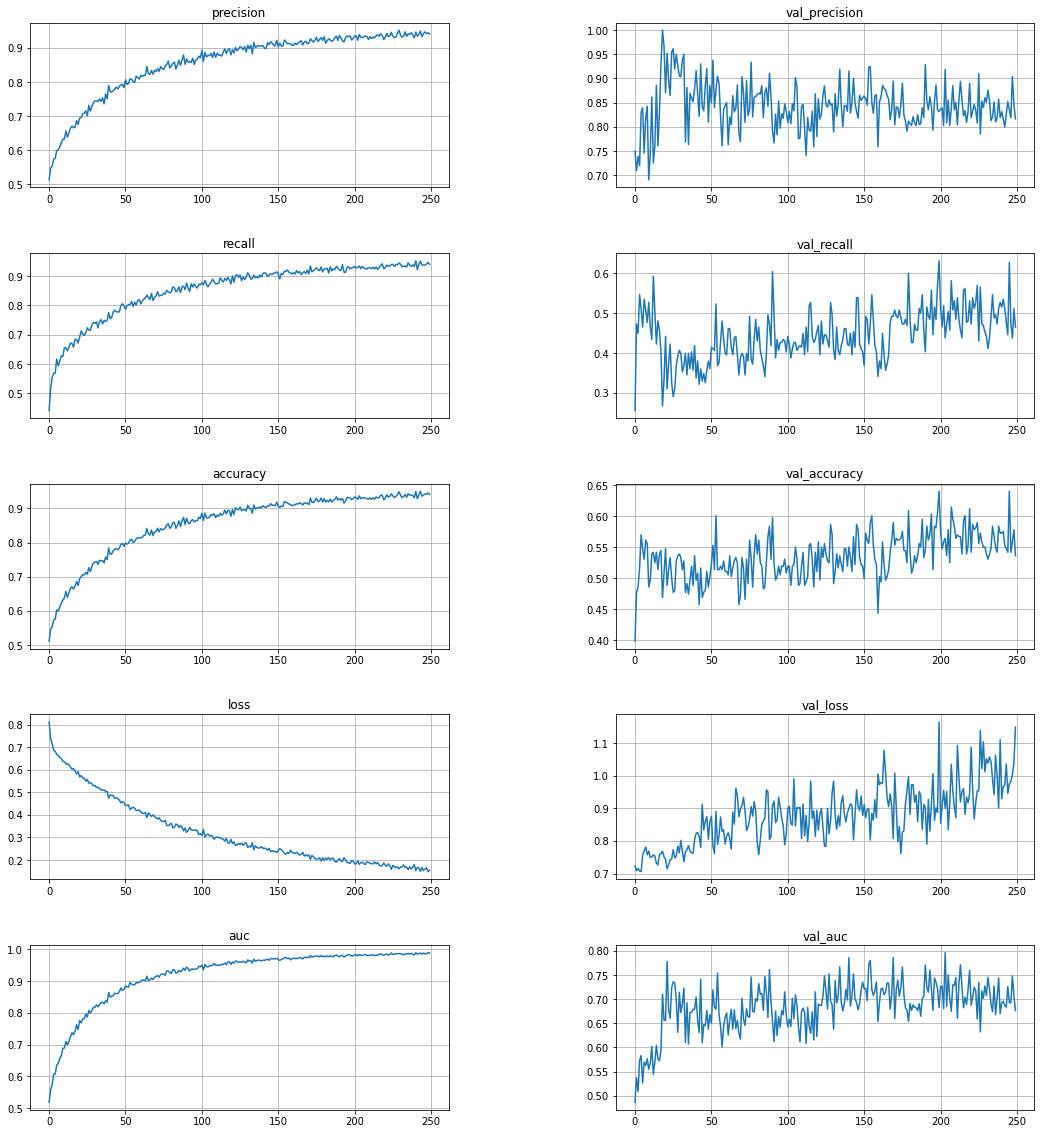

In [12]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['precision', 'recall', 'accuracy', 'loss', 'auc']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, metric in enumerate(plotted_metrics):
    ax = plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    ax.grid()
    
    ax = plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])
    ax.grid()

plt.show()

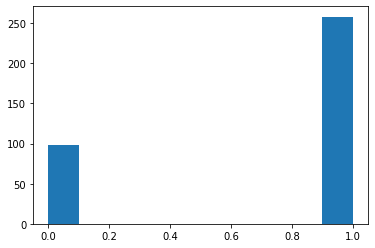

1.0    258
0.0     98
dtype: int64

In [13]:
plt.hist(Y_test)
plt.show()

pd.Series(Y_test).value_counts()

**LIME** Let's use LIME algorithm in order to explain local predictions

In [155]:
import numpy as np
import sklearn
from lime import explanation
from lime import lime_base
import math

def pred_wrapper(input):
    results = model.predict_proba(input)
    return np.array(list(map(lambda x: [1-x[0], x[0]], results)))


class LimeTimeSeriesExplanation(object):
    """Explains time series classifiers."""

    def __init__(self,
                 kernel_width=25,
                 verbose=False,
                 class_names=None,
                 feature_selection='auto',
                 ):
        """Init function.
        Args:
            kernel_width: kernel width for the exponential kernel
            verbose: if true, print local prediction values from linear model
            class_names: list of class names, ordered according to whatever the
            classifier is using. If not present, class names will be '0',
                '1', ...
            feature_selection: feature selection method. can be
                'forward_selection', 'lasso_path', 'none' or 'auto'.
        """

        # exponential kernel
        def kernel(d): return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

        self.base = lime_base.LimeBase(kernel, verbose)
        self.class_names = class_names
        self.feature_selection = feature_selection

    def explain_instance(self,
                         timeseries,
                         classifier_fn,
                         training_set,
                         num_slices,
                         labels=(1,),
                         top_labels=None,
                         num_features=10,
                         num_samples=5000,
                         distance_metric='cosine',
                         model_regressor=None,
                         replacement_method='mean'):
        """Generates explanations for a prediction.
        Args:
            time_series: Time Series to be explained.
            classifier_fn: classifier prediction probability function
            num_slices: Defines into how many slices the series will be split up
            labels: iterable with labels to be explained.
            top_labels: if not None, ignore labels and produce explanations for
            the K labels with highest prediction probabilities, where K is
            this parameter.
            num_features: maximum number of features present in explanation
            num_samples: size of the neighborhood to learn the linear model
            distance_metric: the distance metric to use for sample weighting,
            defaults to cosine similarity
            model_regressor: sklearn regressor to use in explanation. Defaults
            to Ridge regression in LimeBase. Must have model_regressor.coef_
            and 'sample_weight' as a parameter to model_regressor.fit()
        Returns:
            An Explanation object (see explanation.py) with the corresponding
            explanations.
       """
        domain_mapper = explanation.DomainMapper()
        data, _, yss, distances = self.__data_labels_distances(timeseries, classifier_fn, num_samples, num_slices,
                                                            training_set, replacement_method)
        if self.class_names is None:
            self.class_names = [str(x) for x in range(yss[0].shape[0])]
            
        print('class_names: ', self.class_names)
        ret_exp = explanation.Explanation(domain_mapper=domain_mapper, class_names=self.class_names)
        ret_exp.predict_proba = yss[0]
        print('labels: ', labels)
        for label in labels:
            (ret_exp.intercept[int(label)],
             ret_exp.local_exp[int(label)],
             ret_exp.score, ret_exp.local_pred) = self.base.explain_instance_with_data(data, yss, distances, label,
                                                                                       num_features,
                                                                                       feature_selection=self.feature_selection)
        ret_exp.local_exp = {k: [(int(j1), float(j2)) for j1, j2 in v] for k, v in ret_exp.local_exp.items()}
        return ret_exp

    @classmethod
    def __data_labels_distances(cls,
                                time_series,
                                classifier_fn,
                                num_samples,
                                num_slices,
                                training_set,
                                replacement_method='mean'):
        """Generates a neighborhood around a prediction.
        Generates neighborhood data by randomly removing words from
        the instance, and predicting with the classifier. Uses cosine distance
        to compute distances between original and perturbed instances.
        Args:
            time_series: Time Series to be explained.
            classifier_fn: classifier prediction probability function, which
                takes a time series and outputs prediction probabilities. For
                ScikitClassifier, this is classifier.predict_proba.
            num_samples: size of the neighborhood to learn the linear model
            num_slices: how many slices the time series will be split into for discretization.
            training_set: set of which the mean will be computed to use as 'inactive' values.
            replacement_method: Defines how individual slice will be deactivated (can be 'mean', 'total_mean', 'noise')
        Returns:
            A tuple (data, labels, distances), where:
                data: dense num_samples * K binary matrix, where K is the
                    number of tokens in indexed_string. The first row is the
                    original instance, and thus a row of ones.
                labels: num_samples * L matrix, where L is the number of target
                    labels
                distances: cosine distance between the original instance and
                    each perturbed instance (computed in the binary 'data'
                    matrix), times 100.
        """

        def distance_fn(x):
            return sklearn.metrics.pairwise.pairwise_distances(
                x, x[0].reshape([1, -1]), metric='cosine').ravel() * 100

        # split time_series into slices
        values_per_slice = math.ceil(len(time_series) / num_slices)

        # compute randomly how many slices will be switched off
        sample = np.random.randint(1, num_slices + 1, num_samples - 1)
        data = np.ones((num_samples, num_slices))
        features_range = range(num_slices)
        inverse_data = np.array([time_series.copy()])

        for i, size in enumerate(sample, start=1):
            inactive = np.random.choice(features_range, size, replace=False)
            # set inactive slice to mean of training_set
            data[i, inactive] = 0
            tmp_series = time_series.copy()

            for i, inact in enumerate(inactive, start=1):
                index = inact * values_per_slice
                if replacement_method == 'mean':
                    # use mean as inactive
                    tmp_series[index:(index + values_per_slice)] = np.mean(
                        training_set[:, index:(index + values_per_slice)].mean())
                elif replacement_method == 'noise':
                    # use random noise as inactive
                    tmp_series[index:(index + values_per_slice)] = np.random.uniform(min(training_set.min()),
                                                                                     max(training_set.max()), len(
                            tmp_series[index:(index + values_per_slice)]))
                elif replacement_method == 'total_mean':
                    # use total mean as inactive
                    tmp_series[index:(index + values_per_slice)] = np.mean(training_set.mean())
            inverse_data = np.append(inverse_data, np.array([tmp_series]), axis=0)
        labels = classifier_fn(inverse_data)
        distances = distance_fn(data)
        return data, inverse_data, labels, distances
    
    

explainator = LimeTimeSeriesExplanation()

num_slices = 50
num_features = 50

explaination = explainator.explain_instance(timeseries=sample, 
                                            classifier_fn=pred_wrapper,
                                            training_set=X_train,
                                            num_slices=num_slices,
                                            num_features=num_features)


class_names:  ['0', '1']
labels:  (1,)


Sample Label:  1.0
Prediction:  [[0.9755152]]


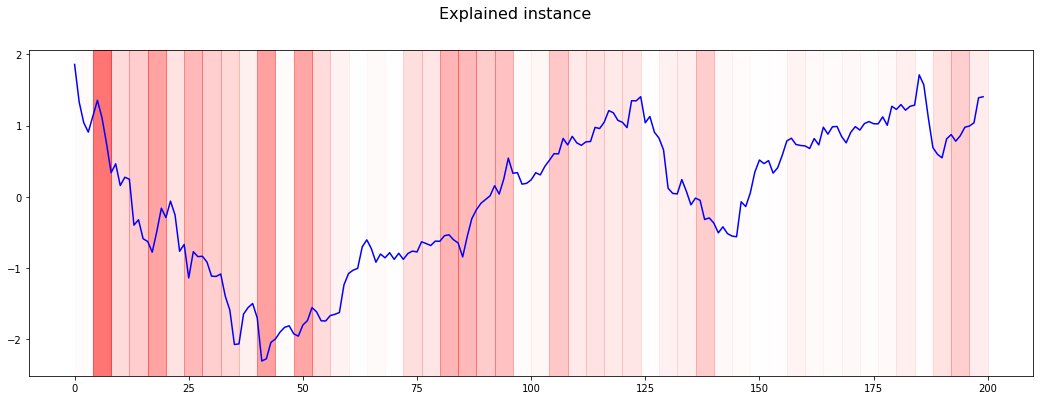

In [166]:
sample_no = 190

sample = X_test[sample_no]
sample_prediction = model.predict(np.array([sample]))
sample_Y = Y_test[sample_no]
print("Sample Label: ", sample_Y)
print("Prediction: ", sample_prediction)

values_per_slice = math.ceil(len(sample) / num_slices)
fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Explained instance', fontsize=16)

plt.plot(sample, color='b')
for i in range(num_features):
    feature, weight = explaination.as_list()[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    plt.axvspan(start , end, color='red', alpha=abs(weight*2))
plt.show()